In [1]:
import pandas as pd
import numpy as np
import os
import pathlib
import pickle
import time
from tqdm.notebook import tqdm

In [136]:
import torch
import torchvision
from torch import nn, optim
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import DataLoader, Dataset
from skimage import io, transform
from sklearn.metrics import classification_report, auc, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

In [3]:
DATASET_PATH = '/home/ilambda/goods_viewer/Debasish/dataset/'
TRAIN_IMAGE_PATH = '/home/ilambda/goods_viewer/Debasish/dataset/1_train_split/whole_resize'
TEST_IMAGE_PATH = '/home/ilambda/goods_viewer/Debasish/dataset/1_eval_img_resize/'
BATCH_SIZE = 32

### Load the dataframes containing feature details

In [4]:
training_df = pd.read_csv('attributes_training_df.csv', index_col='index')
testing_df = pd.read_csv('attributes_testing_df.csv', index_col='index')

In [5]:
# The list of features
with open('all_features.pickle', 'rb') as f:
    all_features = pickle.load(f)

### Class to create Dataset for our model

In [6]:
class ImageFeaturesDataSet(Dataset):
    def __init__(self, df, y_cols, imagedir, x_col='filename', transform=None):
        self.df = df
        self.y_cols = y_cols
        self.imagedir = imagedir
        self.x_col = x_col
        self.df.reset_index(inplace=True, drop=True)
        self.filenames = list(df[x_col].values)
        self.idx = 0
        self.transform = transform
        
    def __getitem__(self, idx):
        im = io.imread(os.path.join(self.imagedir, self.filenames[idx]))
        im = im /255.
        #sample = (im, self.labels[idx])
        if self.transform:
            # to avoid the type mismatch error. ToTensor() expects a float32
            im = im.astype(np.float32)
            im = self.transform(im)
        sample = (im, torch.tensor(self.df.iloc[idx][self.y_cols].values.astype(np.long)).type(torch.float32))
        return sample
    
    def __len__(self):
        return len(self.filenames)

### Custom metrics functions

In [135]:
def classifications_at_threshold(actuals, outputs, threshold):
    # The clone is very imp else it modifies the original tensor
    outputs = outputs.clone()
    preds = outputs.apply_(lambda x: 1 if x >= threshold else 0)
    tp = torch.sum((actuals == 1) & (preds == 1))
    tn = torch.sum((actuals == 0) & (preds == 0))
    fp = torch.sum((actuals == 0) & (preds == 1))
    fn = torch.sum((actuals == 1) & (preds == 0))
    
    return tp, tn, fp, fn

def calc_pres_recall(actuals, outputs):
    pres_list = []
    rec_list = []
    thresholds = [x/100 for x in range(0,101)]
    for threshold in thresholds:
        results = classifications_at_threshold(actuals, outputs, threshold)
        pres_list.append(precision(*results))
        rec_list.append(recall(*results))
    return pres_list, rec_list

def classifications(actuals, preds):
    tp = torch.sum((actuals == 1) & (preds == 1))
    tn = torch.sum((actuals == 0) & (preds == 0))
    fp = torch.sum((actuals == 0) & (preds == 1))
    fn = torch.sum((actuals == 1) & (preds == 0))
    
    return tp, tn, fp, fn

def precision(tp, tn, fp, fn):
    deno = tp + fp
    if deno.item() == 0:
        return 0.
    precision = tp.type(torch.float)/(tp+fp)
    return precision.item()

def recall(tp, tn, fp, fn):
    deno = tp + fn
    if deno.item() == 0:
        return 0.
    recall = tp.type(torch.float)/(tp+fn)
    
    return recall.item()

def f1score(actuals, preds):
    classi = classifications(actuals, preds)
    prec = precision(*classi)
    rec = recall(*classi)
    deno = prec + rec
    if deno == 0:
        return 0.
    f1score = 2*prec*rec/(prec+rec)
    return f1score

def calculate_f1(prec, rec):
    deno = prec + rec
    if deno == 0:
        return 0.0
    f1 = 2*prec*rec/(prec+rec)
    return f1
    

### Create Training Data Loaders

In [10]:
train_df, val_df = train_test_split(training_df, test_size=0.25)

In [11]:
print(train_df.shape)
print(val_df.shape)

(72147, 232)
(24050, 232)


In [53]:
training_transforms = Compose([ToTensor(), Normalize((0.2,0.2,0.2),(0.5,0.5,0.5))])

train_ds = ImageFeaturesDataSet(train_df, all_features, TRAIN_IMAGE_PATH, transform=training_transforms)
train_gen = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

val_ds = ImageFeaturesDataSet(val_df, all_features, TRAIN_IMAGE_PATH, transform=training_transforms)
val_gen = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

### Train, validate and test functions

In [55]:
def validate(args, model, val_gen, bce_loss):
    results = {}
    model.eval()
    all_preds = []
    all_labels = []
    tps, tns, fps, fns = torch.tensor(0), torch.tensor(0), torch.tensor(0), torch.tensor(0)
    val_loss = 0.0
    for images, labels in val_gen:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        outputs = model(images)
        outputs = nn.Sigmoid()(outputs)
        loss = bce_loss(outputs, labels)
        val_loss += loss.cpu().item() * labels.size(0)
        preds = outputs.cpu().data.apply_(lambda x: 1 if x >= 0.5 else 0)
        all_labels.append(labels.detach().cpu())
        all_preds.append(outputs.detach().cpu())
        tp, tn, fp, fn = classifications(labels.cpu(), preds)
        tps += tp
        tns += tn
        fps += fp
        fns += fn
    val_auc = roc_auc_score(torch.cat(all_labels).flatten(), torch.cat(all_preds).flatten())
    val_loss = val_loss / (len(val_gen) * BATCH_SIZE)
    prec = precision(tps, tns, fps, fns)
    rec = recall(tps, tns, fps, fns)
    f1 = calculate_f1(prec, rec)
    results['val_loss'] = val_loss
    results['val_tps'] = tps.cpu().item()
    results['val_tns'] = tns.cpu().item()
    results['val_fps'] = fps.cpu().item()
    results['val_fns'] = fns.cpu().item()
    results['val_precision'] = prec
    results['val_recall'] = rec
    results['val_f1'] = f1
    results['val_auc'] = val_auc
    
    return results

def train(args, model, training_gen, val_gen):
    
    history = {'loss': [], 'tp': [], 'tn': [], 'fp': [], 'fn': [], 'precision': [], 'recall': [], 'f1': [], 'auc': [],
              'val_loss': [], 'val_tp': [], 'val_tn': [], 'val_fp': [], 'val_fn': [], 'val_precision': [], 'val_recall': [], 'val_f1': [], 'val_auc': []}
    adam = torch.optim.Adam(model.parameters(),lr=args['lr'])
    bce_loss = torch.nn.BCELoss()
    if torch.cuda.is_available():
        torch.cuda.set_device('cuda:1')
        model.cuda()
    epochs = args['epochs']
    
    for epoch in range(epochs):
        #print(f"epoch: {epoch+1} started...")
        start = time.time()
        model.train()
        train_loss = 0.0 
        all_labels, all_preds = [], []
        tps, tns, fps, fns = torch.tensor(0), torch.tensor(0), torch.tensor(0), torch.tensor(0)
        for batch, (images, labels) in tqdm(enumerate(training_gen),desc=f'epoch: {epoch+1} ', total=len(training_gen)):
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            adam.zero_grad()
            outputs = model(images)
            outputs = nn.Sigmoid()(outputs)
            preds = outputs.cpu().data.apply_(lambda x: 1 if x >= 0.5 else 0)
            loss = bce_loss(outputs, labels)
            train_loss += loss.cpu().item() * labels.size(0)
            loss.backward()
            adam.step()
            tp, tn, fp, fn = classifications(labels.cpu(), preds)
            tps += tp
            tns += tn
            fps += fp
            fns += fn
            all_preds.append(outputs.detach().cpu())
            all_labels.append(labels.detach().cpu())
        train_auc = roc_auc_score(torch.cat(all_labels).flatten(), torch.cat(all_preds).flatten())
        prec = precision(tps, tns, fps, fns)
        rec = recall(tps, tns, fps, fns)
        f1 = calculate_f1(prec, rec)
        with torch.no_grad():
            val_results = validate(args, model, val_gen, bce_loss)
        end = time.time()
        duration = (end - start)/60
        train_loss = train_loss / (len(training_gen) * BATCH_SIZE)   
        print(f"epoch: {epoch+1}, duration: {duration: 0.2f} mins")
        print(f"loss: {train_loss: 0.4f}, precision: {prec: 0.4f}, recall: {rec: 0.4f}, f1: {f1: 0.4f}, auc: {train_auc: 0.4f}") 
        print(f"val_loss: {val_results['val_loss']: 0.4f}, val_precision: {val_results['val_precision']: 0.4f}, val_recall: {val_results['val_recall']: 0.4f}, val_f1: {val_results['val_f1']: 0.4f}, val_auc: {val_results['val_auc']: 0.4f}")
        history['loss'].append(train_loss)
        history['tp'].append(tps.cpu().item())
        history['tn'].append(tns.cpu().item())
        history['fp'].append(fps.cpu().item())
        history['fn'].append(fns.cpu().item())
        history['precision'].append(prec)
        history['recall'].append(rec)
        history['f1'].append(f1)
        history['auc'].append(train_auc)
        history['val_loss'].append(val_results['val_loss'])
        history['val_tp'].append(val_results['val_tps'])
        history['val_tn'].append(val_results['val_tns'])
        history['val_fp'].append(val_results['val_fps'])
        history['val_fn'].append(val_results['val_fns'])
        history['val_precision'].append(val_results['val_precision'])
        history['val_recall'].append(val_results['val_recall'])
        history['val_f1'].append(val_results['val_f1'])
        history['val_auc'].append(val_results['val_auc'])
        
    torch.save(model, 'feature_detection_model1.pickle')
    return history

### Load the Resnet Model with pre-trained weights

In [56]:
args = {'epochs': 10, 'lr': 0.00001}

In [57]:
resnet = torchvision.models.resnet50(pretrained=True, progress=False)
resnet.fc = nn.Linear(in_features=resnet.fc.in_features, out_features=len(all_features))

### Train the model

In [58]:
history = train(args, resnet, train_gen, val_gen)


epoch: 1, duration:  14.18 mins
loss:  0.1394, precision:  0.5712, recall:  0.3258, f1:  0.4149, auc:  0.8962
val_loss:  0.0964, val_precision:  0.7216, val_recall:  0.4382, val_f1:  0.5453, val_auc:  0.9517



epoch: 2, duration:  14.17 mins
loss:  0.0932, precision:  0.7311, recall:  0.4442, f1:  0.5526, auc:  0.9558
val_loss:  0.0887, val_precision:  0.7309, val_recall:  0.4798, val_f1:  0.5793, val_auc:  0.9608



epoch: 3, duration:  14.20 mins
loss:  0.0873, precision:  0.7412, recall:  0.4786, f1:  0.5816, auc:  0.9627
val_loss:  0.0855, val_precision:  0.7320, val_recall:  0.5017, val_f1:  0.5953, val_auc:  0.9645



epoch: 4, duration:  14.12 mins
loss:  0.0836, precision:  0.7486, recall:  0.5015, f1:  0.6006, auc:  0.9666
val_loss:  0.0839, val_precision:  0.7351, val_recall:  0.5108, val_f1:  0.6027, val_auc:  0.9664



epoch: 5, duration:  14.15 mins
loss:  0.0807, precision:  0.7555, recall:  0.5215, f1:  0.6171, auc:  0.9695
val_loss:  0.0829, val_precision:  0.7294, val_recall:  0.5257, val_f1:  0.6110, val_auc:  0.9676



epoch: 6, duration:  14.19 mins
loss:  0.0780, precision:  0.7629, recall:  0.5391, f1:  0.6317, auc:  0.9719
val_loss:  0.0825, val_precision:  0.7254, val_recall:  0.5333, val_f1:  0.6147, val_auc:  0.9680



epoch: 7, duration:  14.17 mins
loss:  0.0754, precision:  0.7706, recall:  0.5570, f1:  0.6466, auc:  0.9740
val_loss:  0.0823, val_precision:  0.7275, val_recall:  0.5373, val_f1:  0.6181, val_auc:  0.9684



epoch: 8, duration:  14.19 mins
loss:  0.0728, precision:  0.7791, recall:  0.5748, f1:  0.6615, auc:  0.9761
val_loss:  0.0829, val_precision:  0.7169, val_recall:  0.5432, val_f1:  0.6181, val_auc:  0.9681



epoch: 9, duration:  14.23 mins
loss:  0.0701, precision:  0.7879, recall:  0.5919, f1:  0.6760, auc:  0.9780
val_loss:  0.0835, val_precision:  0.7130, val_recall:  0.5484, val_f1:  0.6200, val_auc:  0.9679



epoch: 10, duration:  14.23 mins
loss:  0.0675, precision:  0.7970, recall:  0.6107, f1:  0.6915, auc:  0.9798
val_loss:  0.0846, val_precision:  0.7037, val_recall:  0.5522, val_f1:  0.6188, val_auc:  0.9672


In [23]:
with open('object_detection_history.pickle', 'wb') as f:
    pickle.dump(history, f)

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline

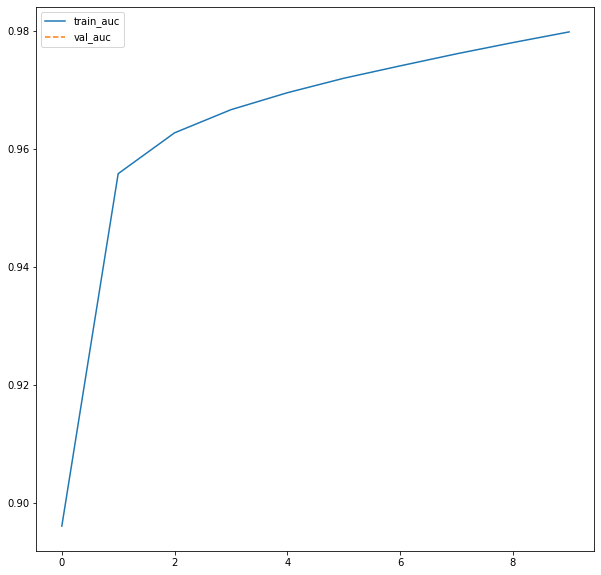

In [64]:
plt.figure(figsize=(10,10))
plt.plot(history['auc'], label='train_auc')
plt.plot(history['val_auc'], linestyle='--', label="val_auc")
plt.legend()
plt.show()

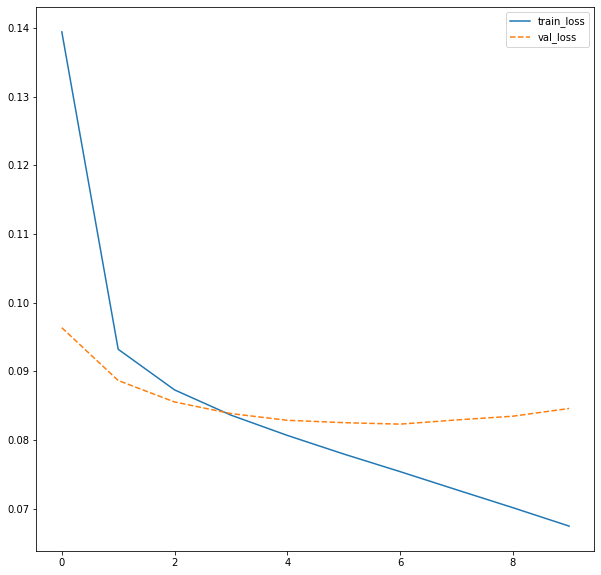

In [63]:
plt.figure(figsize=(10,10))
plt.plot(history['loss'], label='train_loss')
plt.plot(history['val_loss'], linestyle='--', label="val_loss")
plt.legend()
plt.show()

### Load testing data

In [66]:
test_ds = ImageFeaturesDataSet(testing_df, all_features, TEST_IMAGE_PATH, transform=training_transforms)
test_gen = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

### Load trained model

In [80]:
with open('feature_detection_model1.pickle', 'rb') as f:
    loaded_model = torch.load(f)

### Evalution

In [83]:
all_preds = []
all_labels = []
resnet.eval()
if torch.cuda.is_available():
    loaded_model.cuda()
with torch.no_grad():
    for images, labels in tqdm(test_gen, total=len(test_gen)):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = loaded_model(images)
        outputs = nn.Sigmoid()(outputs)
        all_labels.append(labels.cpu())
        all_preds.append(outputs.cpu())

In [128]:
o = torch.cat(all_preds)
l = torch.cat(all_labels)
p,r = calc_pres_recall(l, o)

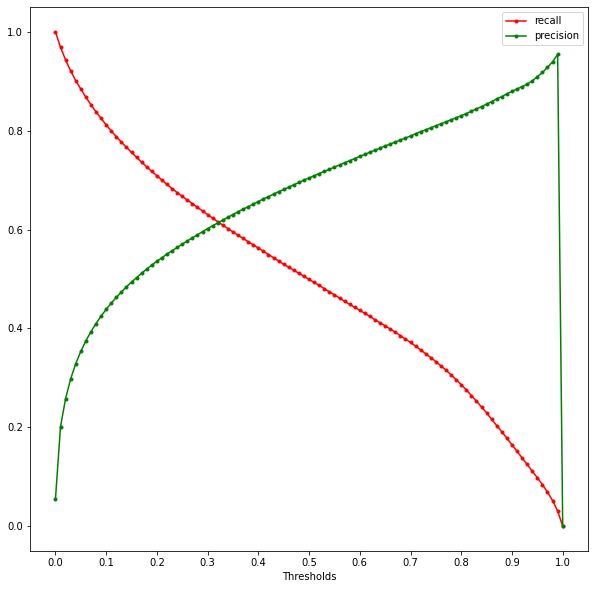

In [134]:
plt.figure(figsize=(10,10))
plt.plot(r, marker='.', color='red', label='recall')
plt.plot(p, marker='.', color='green', label='precision')
plt.legend()
plt.xlabel("Thresholds")
plt.xticks([i for i in range(0,101,10)], labels=[i/100 for i in range(0,101,10)])
plt.show()